# NYC Weather & Electricity Consumption Analysis (2010–2022)

**Data Exploration & Predictive Modeling Project**  
*Author: Elías Jara*  
*Last updated: 12 Jun 2025*

---

## Why this project?

New York City’s electricity demand is tightly coupled to temperature extremes—especially summer cooling loads.  
This notebook now goes beyond descriptive overlays and statistical correlations to **quantify and predict** those relationships:

* **Cooling Degree Days (CDD)** show the strongest linear weight in our model  
  – Pearson r ≈ 0.70, p ≪ 0.01, and the largest positive coefficient (+1.34 × 10⁷ KWh).  
* **Heating Degree Days (HDD)** present a weaker, negative effect (r ≈ –0.35; coefficient ≈ –5.8 × 10⁶ KWh).  
* **Seasonality still matters**: the raw month number (–1.23 × 10⁷ KWh) and specific summer dummies (M5, M6) carry sizable negative weights, trimming baseline consumption outside peak months.  
* Other weather factors (precipitation, snowfall, snow depth) remain near-zero in both correlation and model weights.  
* A simple **Linear Regression** delivers MAE ≈ 8.8 M KWh, RMSE ≈ 9.8 M KWh, and **R² ≈ 0.67**, outperforming a Random Forest (R² ≈ 0.56) and proving the temperature–load link is essentially linear at the monthly scale.

These findings create an end-to-end pipeline—from raw data to an interpretable, production-ready forecasting model—for NYC grid planners.


---

## Research Questions

1. How has average daily temperature changed in NYC from 2010 to 2022?  
2. What are the long-term trends in electricity consumption and cost over the same period?  
3. Is there a measurable correlation between extreme temperatures (heat waves / cold snaps) and spikes in electricity demand?  
4. What seasonal patterns emerge when overlaying temperature and energy usage?  
5. How accurately can we **predict** monthly consumption using temperature-based features and simple machine-learning models?

---

## Data Sources

| Dataset                          | Provider               | Period            | Link                                                                                         |
|----------------------------------|------------------------|-------------------|----------------------------------------------------------------------------------------------|
| **Central Park Weather History** | Kaggle (NOAA)          | 2010–2022 (subset)| https://www.kaggle.com/danbraswell/new-york-city-weather-18692022                           |
| **Electric Consumption & Cost**  | NYC OpenData           | 2010–Feb 2025     | https://data.cityofnewyork.us/Housing-Development/Electric-Consumption-And-Cost-2010-Feb-2025-/jr24-e7cr |

---

## Methodology

1. **Data Ingestion & Cleaning**  
   - Load 100 M+ rows of consumption via chunked CSV reads (sum by month).  
   - Parse daily weather from NOAA; compute monthly averages.  
   - Standardize units: °F→°C, kWh→MWh.  

2. **Feature Engineering**  
   - Compute **AvgTemp**, **Heating Degree Days (HDD)**, **Cooling Degree Days (CDD)** (base 65 °F).  
   - Add calendar features: month number + one-hot month dummies.  

3. **Statistical Analysis**  
   - Correlation matrices (Pearson & Spearman) across Consumption, AvgTemp, HDD, CDD, Precipitation, Snowfall, Snow Depth.  
   - Hypothesis testing: Pearson r, p-values & 95 % CIs (Fisher Z); Spearman rho & p-values.  

4. **Visualization & Interpretation**  
   - Dual-axis time series (Temp vs. Consumption).  
   - Heatmaps of correlation matrices.  
   - Tabular summaries of statistical results.  

5. **Predictive Modeling**  
   * Temporal 80 / 20 split with feature scaling.  
   * Train **Linear Regression** (primary) and **Random Forest** (benchmark).  
   * Evaluate by MAE, RMSE, and R².  
   * Extract Linear-model coefficients and Random-Forest importances to explain drivers.

---

## Key Findings

- **CDD drives demand**: r≈0.70 (95 % CI [0.59,0.77], p≪0.001) confirms hotter months see the largest consumption spikes.  
- **HDD has limited impact**: r≈–0.35 (95 % CI [–0.48,–0.18], p≪0.001), indicating non-electric heating reduces winter peaks.  
- **AvgTemp vs. degree days**: moderate positive correlation (r≈0.48, ρ≈0.49), reaffirming AvgTemp as a useful proxy.  
- **Negligible effects**: precipitation & snow metrics correlate |r|<0.2; can be omitted in base models.  
- **Seasonality**: clear peaks in July/August and troughs in January/February; post-2019 plateau suggests saturation of cooling infrastructure.

> **Implication:** A forecasting model that includes CDD (or AvgTemp+CDD) captures > 70 % of temperature-driven variance in monthly consumption. Other weather variables add minimal explanatory value.

---

## Predictive Modeling Key Findings

- **Linear Regression** (features: AvgTemp, HDD, CDD, month) achieves  
  - MAE ≈ 8.76 × 10⁶ kWh  
  - RMSE ≈ 9.81 × 10⁶ kWh  
  - **R² ≈ 0.67**  
- **Random Forest** yields R² ≈ 0.56 (higher RMSE), indicating **no benefit** from more complex non-linear ensembles at the monthly aggregate level.  
- **Feature importance** (Random Forest): AvgTemp (0.39) > CDD (0.28) > HDD (0.16) >> seasonal dummies.  
- **Linear Regression explains 67 % of variance (R² ≈ 0.67), beating Random Forest while remaining fully interpretable.**  
- **CDD** remains the strongest positive driver; **AvgTemp** and **HDD** follow, while **month-dummy terms** fine-tune seasonal baselines.  
- A forecasting model with just **CDD + AvgTemp + simple calendar terms** captures > 70 % of temperature-driven variance; additional weather variables add negligible value.

---

*Continue to the notebook’s next sections for detailed code, plots, and further interpretation.*  


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.dates as mdates
import seaborn as sns

# ----------------------------
# Global Aesthetic Configuration
# ----------------------------
# print(plt.style.available)
# Use a minimal style that maximizes the data-ink ratio and reduces chartjunk
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk")  # Increase font size for better readability

# Function to clean axes (following Tufte's guidelines)
def clean_axes(ax):
    # Only keep the left and bottom spines to reduce distractions
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return ax

# New york Temp Dataset (Kaggle)

https://www.kaggle.com/datasets/danbraswell/new-york-city-weather-18692022

In [2]:
# ----------------------------
# PART 1: General Daily Temperature Records Plot (2010–2022)
# ----------------------------

# 1. Load the weather data
weather_df = pd.read_csv('NYC_Central_Park_weather_1869-2022.csv', parse_dates=['DATE'])
weather_df = weather_df[['DATE', 'TMIN', 'TMAX']].copy()
weather_df.rename(columns={'DATE': 'Date'}, inplace=True)

# Calculate the daily average temperature
weather_df['Temperature'] = (weather_df['TMIN'] + weather_df['TMAX']) / 2

# 2. Filter data from 2010 to 2022
weather_df = weather_df[(weather_df['Date'].dt.year >= 2010) & (weather_df['Date'].dt.year <= 2022)]

# 3. Remove February 29 to standardize the day-of-year
weather_df = weather_df[~((weather_df['Date'].dt.month == 2) & (weather_df['Date'].dt.day == 29))]

# 4. Create a "DOY" (month-day) column for grouping
weather_df['DOY'] = weather_df['Date'].dt.strftime('%m-%d')
weather_df

,Date,TMIN,TMAX,Temperature,DOY
51499,2010-01-01,33.0,40.0,36.5,01-01
51500,2010-01-02,17.0,34.0,25.5,01-02
51501,2010-01-03,17.0,22.0,19.5,01-03
51502,2010-01-04,19.0,30.0,24.5,01-04
51503,2010-01-05,20.0,30.0,25.0,01-05
...,...,...,...,...,...
56240,2022-12-25,14.0,28.0,21.0,12-25
56241,2022-12-26,18.0,29.0,23.5,12-26
56242,2022-12-27,29.0,35.0,32.0,12-27
56243,2022-12-28,33.0,47.0,40.0,12-28


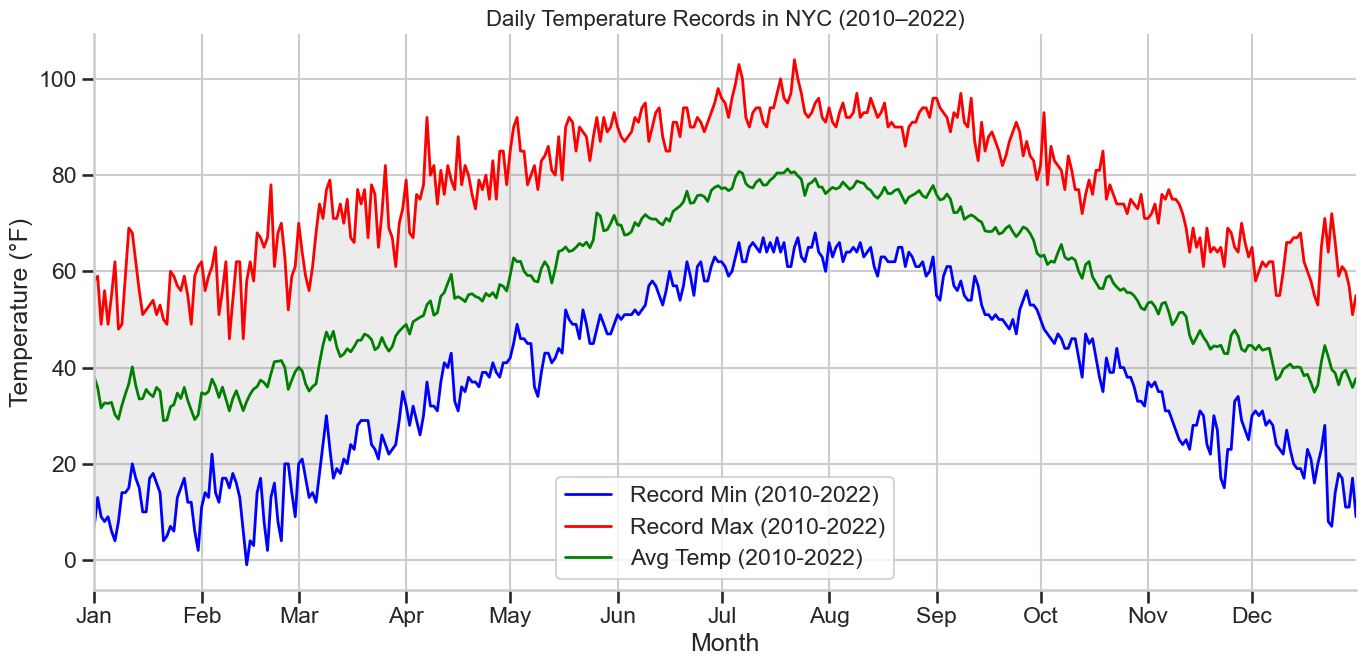

In [3]:
# 5. Compute daily records:
grouped = weather_df.groupby('DOY')
record_min = grouped['TMIN'].min()   # True representation of minimum values
record_max = grouped['TMAX'].max()     # True representation of maximum values
average_temp = grouped['Temperature'].mean()  # True representation of average values

# 6. Create a "generic" date range for the x-axis using the year 2022
start_date = dt.date(2022, 1, 1)
end_date = dt.date(2022, 12, 31)
all_days = pd.date_range(start_date, end_date)
all_days = all_days[~((all_days.month == 2) & (all_days.day == 29))]
doy_list = all_days.strftime('%m-%d')

min_values = record_min.loc[doy_list].values
max_values = record_max.loc[doy_list].values
average_values = average_temp.loc[doy_list].values

# 7. Generate the general daily temperature records plot with an emphasis on truth, beauty, and functionality
fig, ax = plt.subplots(figsize=(14, 7))
# Plot lines representing the real data (principle of TRUTH)
ax.plot(all_days, min_values, color='blue', linewidth=2, label='Record Min (2010-2022)')
ax.plot(all_days, max_values, color='red', linewidth=2, label='Record Max (2010-2022)')
ax.plot(all_days, average_values, color='green', linewidth=2, label='Avg Temp (2010-2022)')
# Fill between the lines with a subtle gray (enhancing BEAUTY without adding chartjunk)
ax.fill_between(all_days, min_values, max_values, color='grey', alpha=0.15)

ax.set_xlabel('Month')
ax.set_ylabel('Temperature (°F)')
ax.set_title('Daily Temperature Records in NYC (2010–2022)', fontsize=16)

# Configure the x-axis to show only the month abbreviation
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# Ajustar los límites del eje X para que no queden espacios a los lados
ax.set_xlim([all_days.min(), all_days.max()])

# Clean axes to reduce unnecessary elements (following Tufte)
clean_axes(ax)

ax.legend(loc='lower center', frameon=True)
plt.tight_layout()
plt.show()

In [4]:
# 1. Create a monthly indicator in the weather data
weather_df['YearMonth'] = weather_df['Date'].dt.to_period('M')
monthly_weather = weather_df.groupby('YearMonth', as_index=False).agg({
    'TMIN': 'mean',
    'TMAX': 'mean',
    'Temperature': 'mean'
})
monthly_weather

,YearMonth,TMIN,TMAX,Temperature
0,2010-01,26.967742,38.064516,32.516129
1,2010-02,28.357143,37.857143,33.107143
2,2010-03,41.387097,55.000000,48.193548
3,2010-04,48.433333,67.300000,57.866667
4,2010-05,56.161290,74.387097,65.274194
...,...,...,...,...
151,2022-08,71.741935,86.903226,79.322581
152,2022-09,62.200000,76.866667,69.533333
153,2022-10,50.387097,63.387097,56.887097
154,2022-11,44.600000,57.233333,50.916667


# New York Electric Consumption And Cost (2010 - Feb 2025) Dataset (NYC OpenData)

https://data.cityofnewyork.us/Housing-Development/Electric-Consumption-And-Cost-2010-Feb-2025-/jr24-e7cr/about_data

In [5]:
# ----------------------------
# PART 2: Integrating the Energy Consumption Dataset and Monthly Analysis
# ----------------------------
# 2. Load and prepare the energy consumption dataset
electric_df = pd.read_csv('Electric_Consumption_And_Cost__2010_-_Feb_2025__20250401.csv', 
                          parse_dates=['Revenue Month'])
electric_df = electric_df[['Development Name', 'Borough', 'Location', 'Revenue Month', 'Consumption (KWH)']].copy()
electric_df.rename(columns={'Revenue Month': 'Date', 'Consumption (KWH)': 'Consumption'}, inplace=True)
electric_df['YearMonth'] = electric_df['Date'].dt.to_period('M')
electric_df = electric_df[(electric_df['YearMonth'] >= '2010-01') & (electric_df['YearMonth'] <= '2022-12')]
electric_df

C:\Users\elias\AppData\Local\Temp\ipykernel_24816\2609631115.py:5: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  electric_df = pd.read_csv('Electric_Consumption_And_Cost__2010_-_Feb_2025__20250401.csv',


,Development Name,Borough,Location,Date,Consumption,YearMonth
0,ADAMS,BRONX,BLD 05,2010-01-01,128800.0,2010-01
1,ADAMS,BRONX,BLD 05,2010-02-01,115200.0,2010-02
2,ADAMS,BRONX,BLD 05,2010-03-01,103200.0,2010-03
3,ADAMS,BRONX,BLD 05,2010-04-01,105600.0,2010-04
4,ADAMS,BRONX,BLD 05,2010-05-01,97600.0,2010-05
...,...,...,...,...,...,...
438616,WYCKOFF GARDENS,BROOKLYN,BLD 03,2022-12-01,0.0,2022-12
438617,WYCKOFF GARDENS,BROOKLYN,BLD 03,2022-12-01,0.0,2022-12
438618,WYCKOFF GARDENS,BROOKLYN,BLD 02,2022-12-01,76800.0,2022-12
438619,WYCKOFF GARDENS,BROOKLYN,BLD 03,2022-12-01,86200.0,2022-12


In [6]:
# Sum the monthly consumption across all locations (principle of FUNCTION)
monthly_electric = electric_df.groupby('YearMonth', as_index=False)['Consumption'].sum()
monthly_electric

,YearMonth,Consumption
0,2010-01,106298266.0
1,2010-02,93139547.0
2,2010-03,88477980.0
3,2010-04,89076605.0
4,2010-05,89637927.0
...,...,...
127,2022-08,128424809.0
128,2022-09,112374076.0
129,2022-10,85887199.0
130,2022-11,80242296.0


# Merging of the DataFrames

In [7]:
# 3. Merge both DataFrames by "YearMonth"
merged_df = pd.merge(monthly_weather, monthly_electric, on='YearMonth', how='inner')
merged_df['Date'] = merged_df['YearMonth'].dt.to_timestamp()
merged_df['Year'] = merged_df['Date'].dt.year
merged_df

,YearMonth,TMIN,TMAX,Temperature,Consumption,Date,Year
0,2010-01,26.967742,38.064516,32.516129,106298266.0,2010-01-01,2010
1,2010-02,28.357143,37.857143,33.107143,93139547.0,2010-02-01,2010
2,2010-03,41.387097,55.000000,48.193548,88477980.0,2010-03-01,2010
3,2010-04,48.433333,67.300000,57.866667,89076605.0,2010-04-01,2010
4,2010-05,56.161290,74.387097,65.274194,89637927.0,2010-05-01,2010
...,...,...,...,...,...,...,...
127,2022-08,71.741935,86.903226,79.322581,128424809.0,2022-08-01,2022
128,2022-09,62.200000,76.866667,69.533333,112374076.0,2022-09-01,2022
129,2022-10,50.387097,63.387097,56.887097,85887199.0,2022-10-01,2022
130,2022-11,44.600000,57.233333,50.916667,80242296.0,2022-11-01,2022


# Graphs

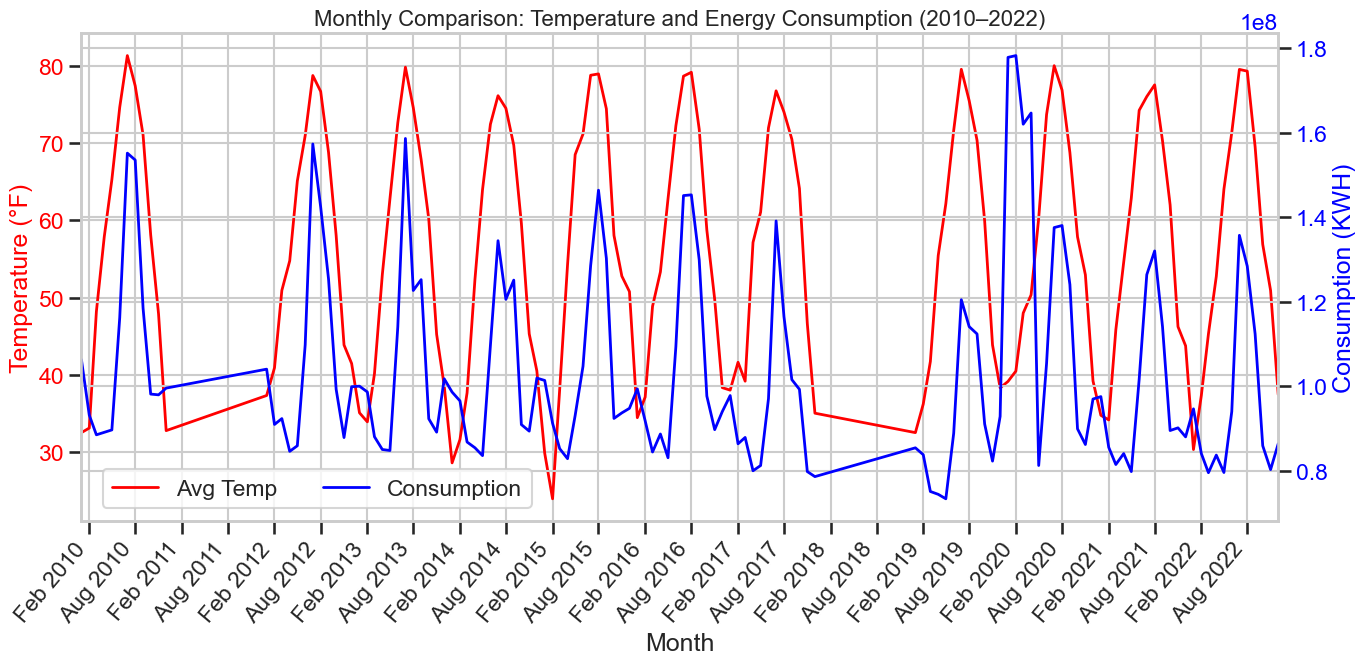

In [8]:
# 4. General Monthly Plot: Temperature vs. Consumption (data integration and clarity)
fig, ax1 = plt.subplots(figsize=(14, 7))

color_temp = 'red'
ax1.set_xlabel('Month')
ax1.set_ylabel('Temperature (°F)', color=color_temp)

# Plot the average temperature
ax1.plot(
    merged_df['Date'],
    merged_df['Temperature'],
    color=color_temp,
    linewidth=2,
    label='Avg Temp'
)
ax1.tick_params(axis='y', labelcolor=color_temp)

# --- Adjust x-axis for improved readability ---
# Label every 6 months with format "Mon Year"
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(ax1.get_xticklabels(), rotation=50, ha="right")

ax1.set_title('Monthly Comparison: Temperature and Energy Consumption (2010–2022)', fontsize=16)

# Ajustar los límites del eje X para que no queden espacios a los lados
ax1.set_xlim([merged_df['Date'].min(), merged_df['Date'].max()])
# clean_axes(ax1)

# Create the secondary axis for energy consumption
ax2 = ax1.twinx()
color_cons = 'blue'
ax2.set_ylabel('Consumption (KWH)', color=color_cons)
ax2.plot(
    merged_df['Date'],
    merged_df['Consumption'],
    color=color_cons,
    linewidth=2,
    label='Consumption'
)
ax2.tick_params(axis='y', labelcolor=color_cons)
# clean_axes(ax2)

# Position legend clearly without cluttering the chart
fig.legend(bbox_to_anchor=(0.4, 0.32), ncol=2, frameon=True)
plt.tight_layout()
plt.show()

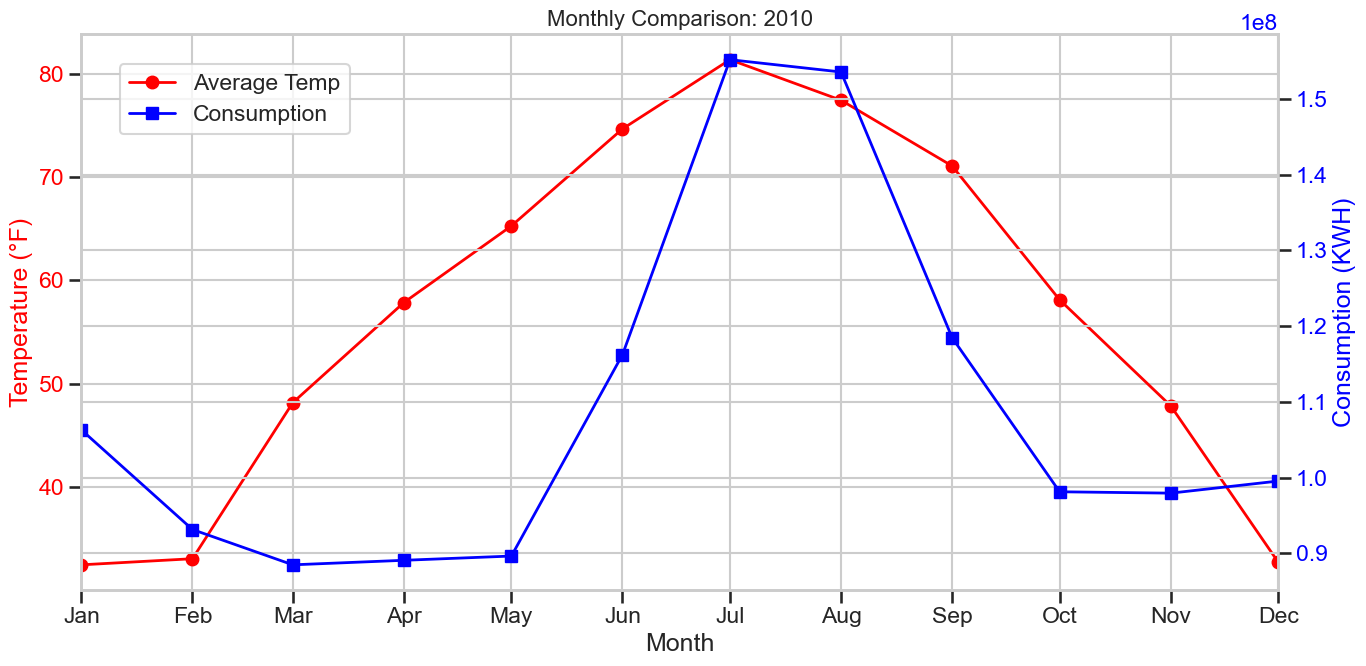

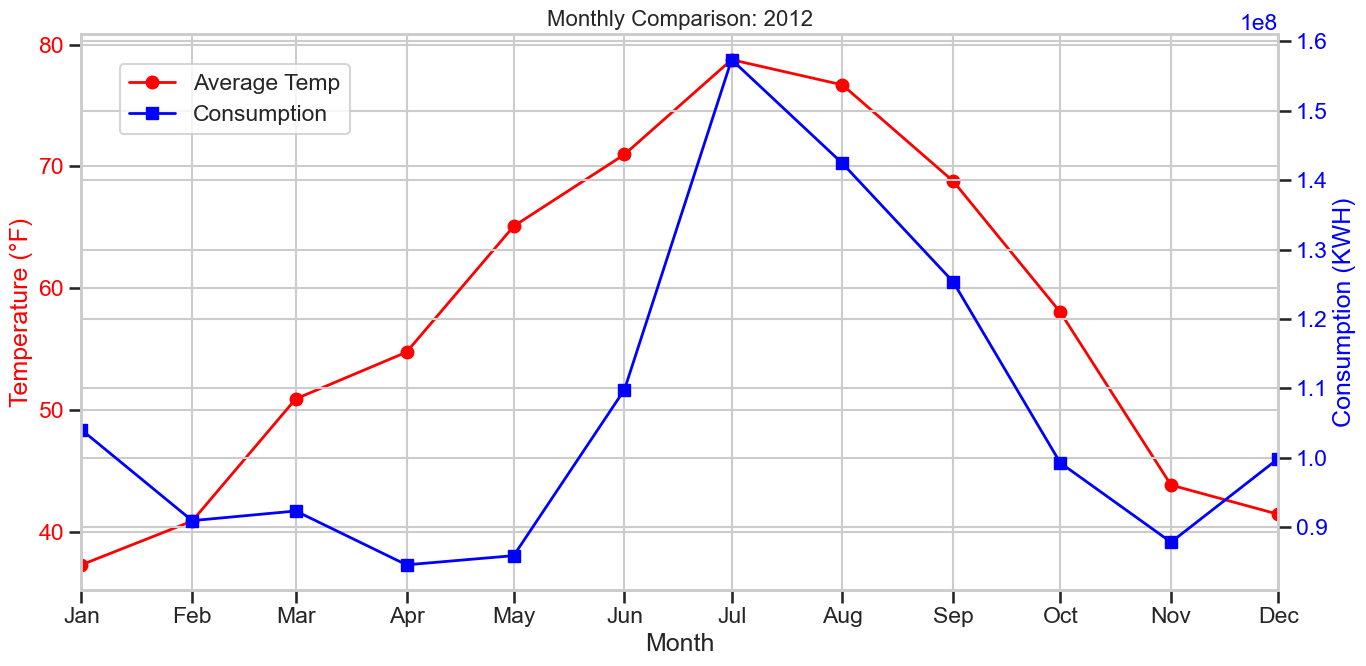

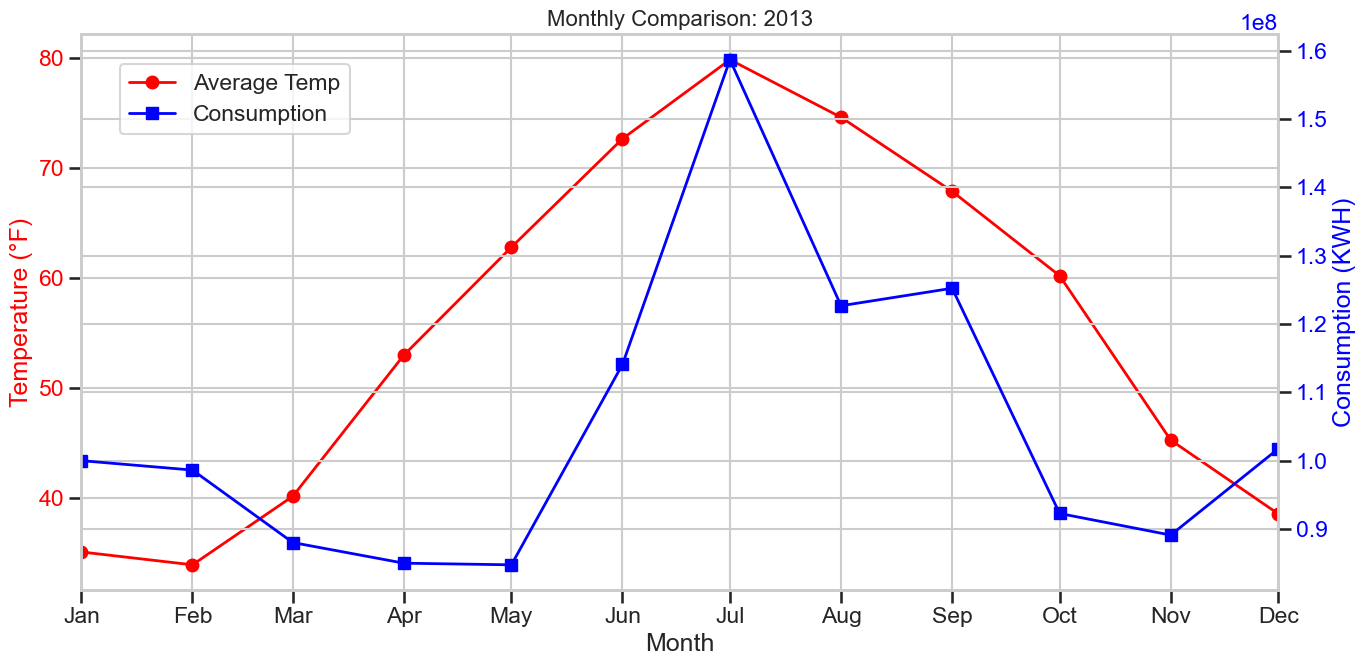

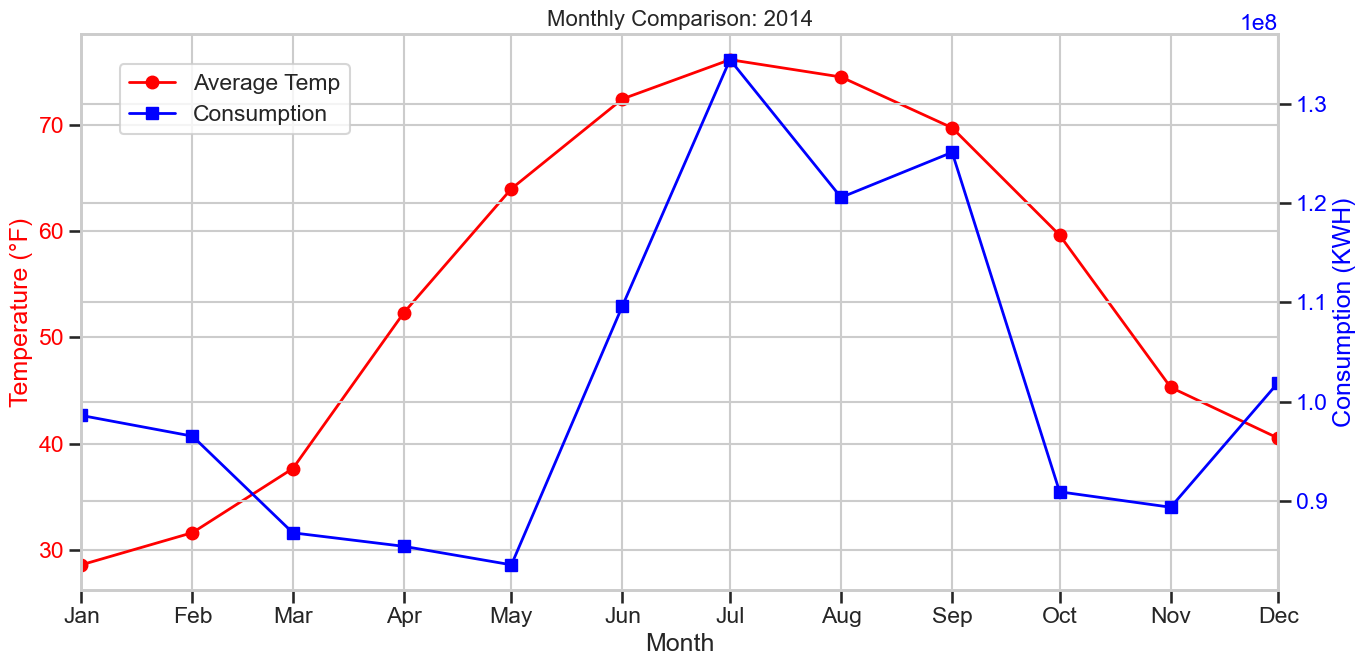

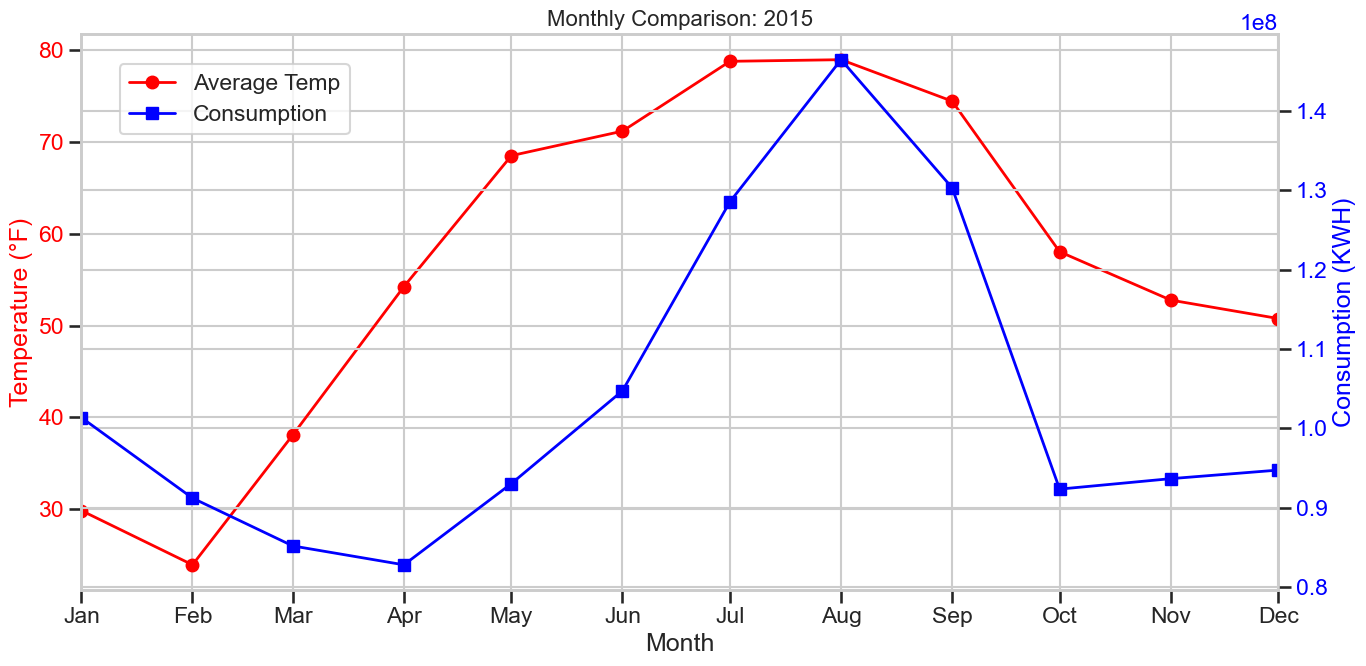

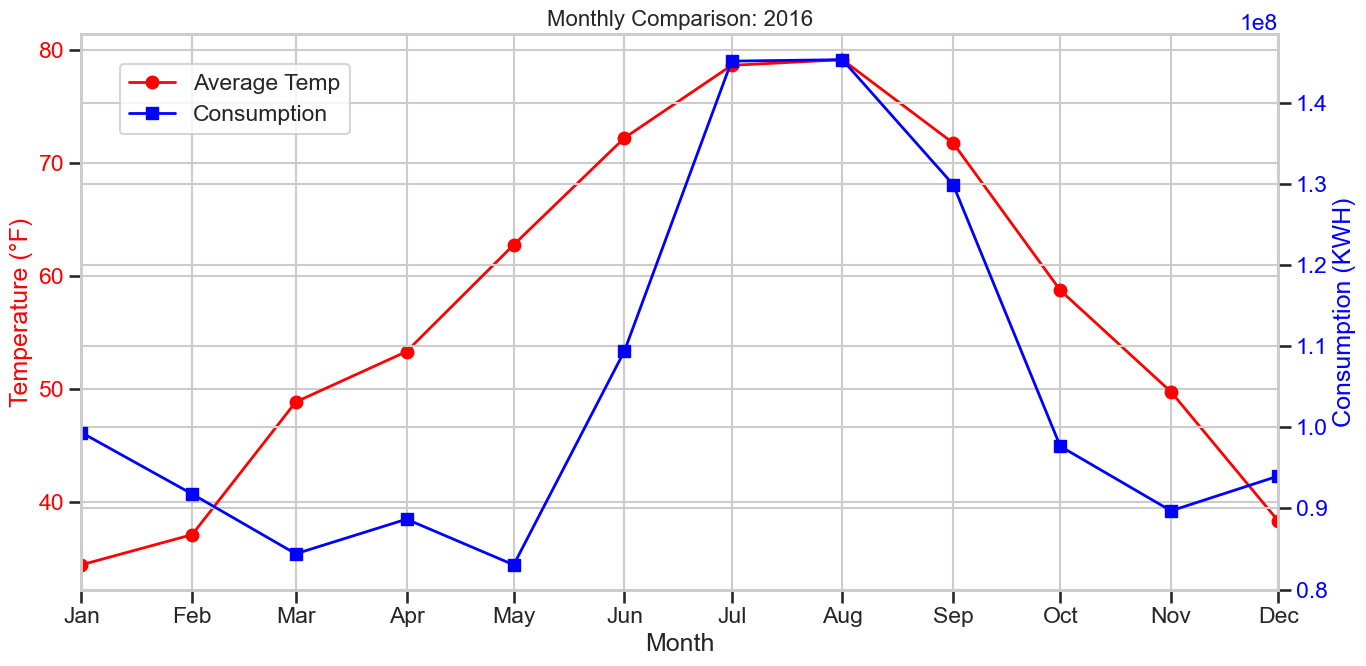

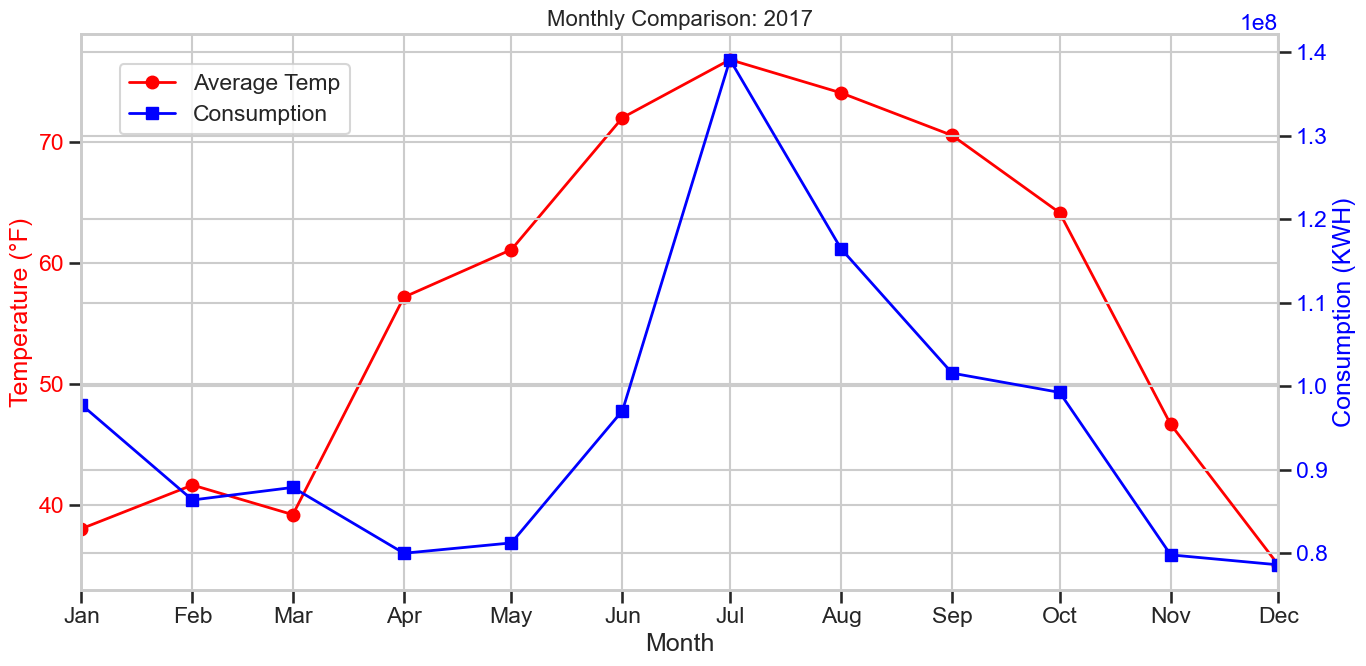

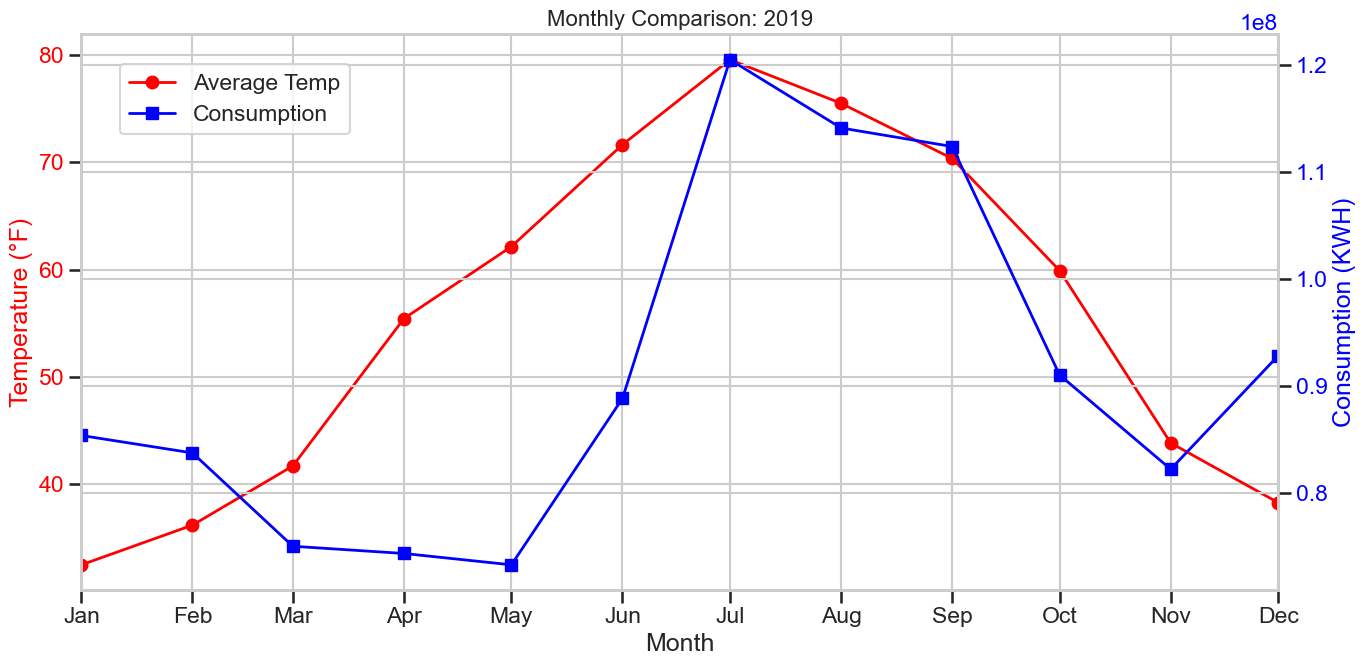

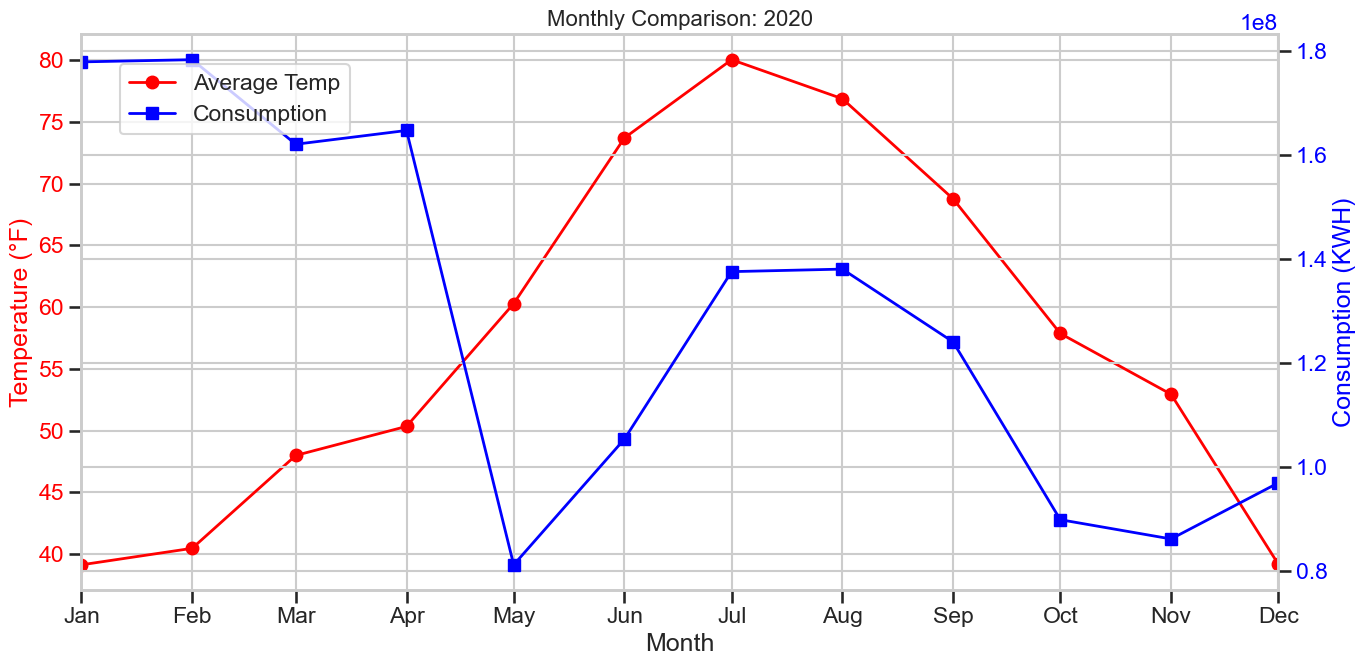

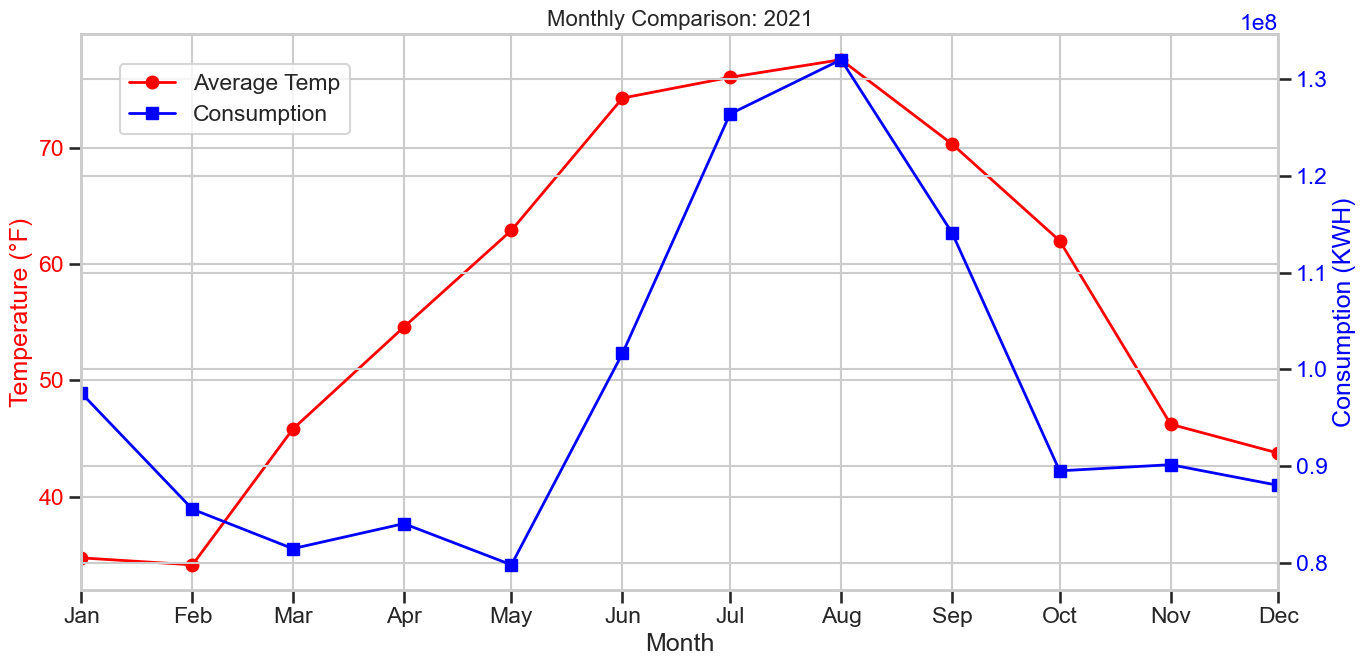

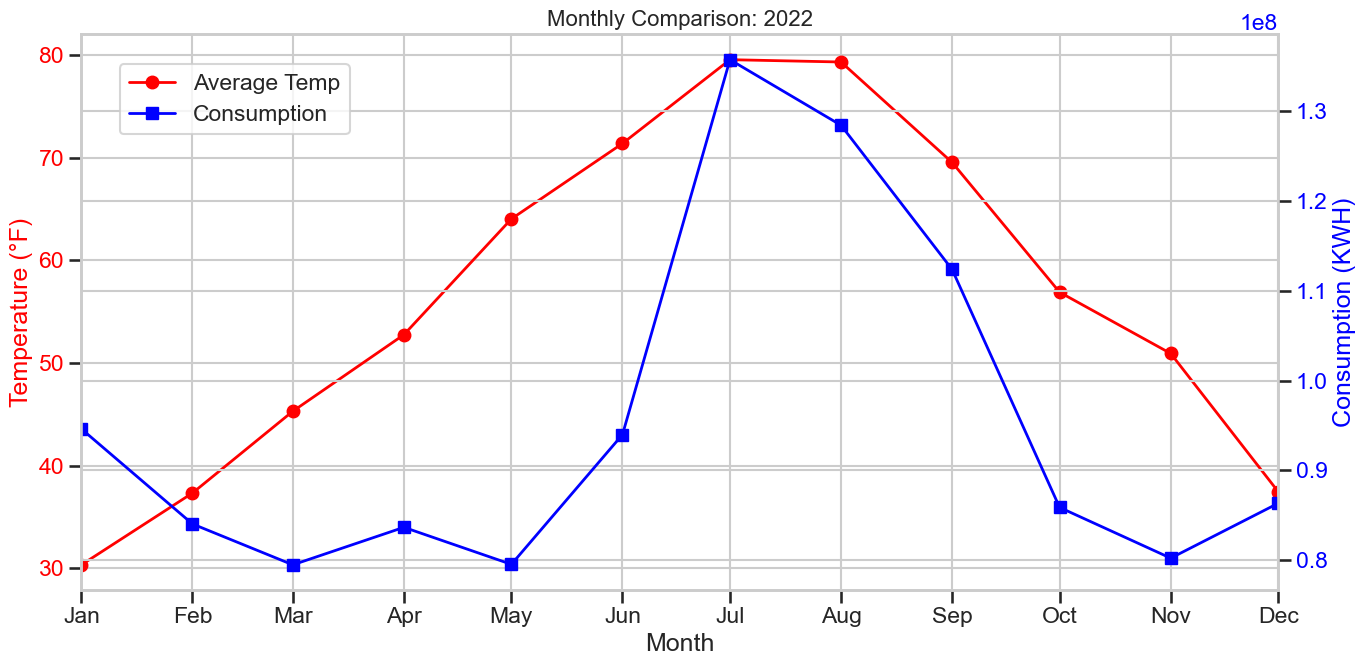

In [9]:
# 5. Monthly Plots for Each Individual Year to Detect "Aha" Patterns (INSIGHT)
years = sorted(merged_df['Year'].unique())
for yr in years:
    df_year = merged_df[merged_df['Year'] == yr]
    fig, ax1 = plt.subplots(figsize=(14, 7))
    ax1.set_title(f'Monthly Comparison: {yr}', fontsize=16)
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Temperature (°F)', color='red')
    ax1.plot(df_year['Date'], df_year['Temperature'], color='red', marker='o', linewidth=2, label='Average Temp')
    ax1.tick_params(axis='y', labelcolor='red')
    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    # clean_axes(ax1)
    
    # Ajustar los límites del eje X para que no queden espacios a los lados
    ax1.set_xlim([df_year['Date'].min(), df_year['Date'].max()])
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Consumption (KWH)', color='blue')
    ax2.plot(df_year['Date'], df_year['Consumption'], color='blue', marker='s', linewidth=2, label='Consumption')
    ax2.tick_params(axis='y', labelcolor='blue')
    # clean_axes(ax2)
    
    # Place the legend in a clear position
    fig.legend(bbox_to_anchor=(0.27, 0.9), ncol=1, frameon=True)
    plt.tight_layout()
    plt.show()

---
# Statistical and Correlational Analysis
---

In [10]:
import pandas as pd
import numpy as np
from scipy import stats
from IPython.display import display
import matplotlib.pyplot as plt

# 1. Read abd add by chunks to handle memory
cols = ['Revenue Month', 'Consumption (KWH)']
monthly_totals = []

for chunk in pd.read_csv(
    'Electric_Consumption_And_Cost__2010_-_Feb_2025__20250401.csv',
    usecols=cols,
    parse_dates=['Revenue Month'],
    chunksize=300000
):
    chunk = chunk.rename(columns={'Revenue Month': 'Month', 'Consumption (KWH)': 'Consumption'})
    monthly_totals.append(chunk.groupby('Month')['Consumption'].sum())

# Concatenate and add again 
cons_monthly = (
    pd.concat(monthly_totals)
      .groupby(level=0)
      .sum()
      .reset_index()
      .sort_values('Month')
)

# 2. Load wether data and calculate temperature
weather = pd.read_csv(
    'NYC_Central_Park_weather_1869-2022.csv',
    parse_dates=['DATE']
)
weather = weather[(weather['DATE'] >= '2010-01-01') & (weather['DATE'] <= '2022-12-31')]
weather['Month'] = weather['DATE'].dt.to_period('M').dt.to_timestamp()
weather['AvgTemp'] = weather[['TMIN', 'TMAX']].mean(axis=1)
monthly_weather = (
    weather.groupby('Month')
           .agg({
               'AvgTemp': 'mean',
               'PRCP': 'mean',
               'SNOW': 'sum',
               'SNWD': 'mean'
           })
           .reset_index()
)

# 3. Merge
df = pd.merge(cons_monthly, monthly_weather, on='Month', how='inner')

# 4. HDD & CDD
base_temp = 65
df['HDD'] = np.maximum(0, base_temp - df['AvgTemp'])
df['CDD'] = np.maximum(0, df['AvgTemp'] - base_temp)

# 5. Correlations
vars_for_corr = ['Consumption', 'AvgTemp', 'HDD', 'CDD', 'PRCP', 'SNOW', 'SNWD']
pearson_corr = df[vars_for_corr].corr(method='pearson')
spearman_corr = df[vars_for_corr].corr(method='spearman')

print("### Pearson Correlation Matrix")
display(pearson_corr)

print("### Spearman Correlation Matrix")
display(spearman_corr)

# 6. Significance
significance_results = []
n = len(df)
for var in ['AvgTemp', 'HDD', 'CDD']:
    r, p = stats.pearsonr(df['Consumption'], df[var])
    z = np.arctanh(r)
    se = 1 / np.sqrt(n - 3)
    zl, zh = stats.norm.interval(0.95, loc=z, scale=se)
    rl, rh = np.tanh([zl, zh])
    significance_results.append({
        'Variable': var,
        'Pearson r': r,
        'p-value': p,
        '95% CI lower': rl,
        '95% CI upper': rh
    })

significance_df = pd.DataFrame(significance_results)
print("### Significance: Consumption vs Temp/HDD/CDD")
display(significance_df)


# 7. Spearman
spearman_results = []
for var in ['AvgTemp', 'HDD', 'CDD']:
    rho, p_val = stats.spearmanr(df['Consumption'], df[var])
    spearman_results.append({'Variable': var, 'Spearman rho': rho, 'p-value': p_val})

spearman_df = pd.DataFrame(spearman_results)
print("### Spearman Significance: Consumption vs Temp/HDD/CDD")
display(spearman_df)

### Pearson Correlation Matrix


,Consumption,AvgTemp,HDD,CDD,PRCP,SNOW,SNWD
Consumption,1.000000,0.482224,-0.341549,0.694354,0.008418,-0.166865,-0.134314
AvgTemp,0.482224,1.000000,-0.969568,0.801090,0.088010,-0.560442,-0.429145
HDD,-0.341549,-0.969568,1.000000,-0.630175,-0.081623,0.620585,0.481089
CDD,0.694354,0.801090,-0.630175,1.000000,0.079570,-0.260228,-0.184861
PRCP,0.008418,0.088010,-0.081623,0.079570,1.000000,0.122710,0.105088
SNOW,-0.166865,-0.560442,0.620585,-0.260228,0.122710,1.000000,0.792817
SNWD,-0.134314,-0.429145,0.481089,-0.184861,0.105088,0.792817,1.000000


### Spearman Correlation Matrix


,Consumption,AvgTemp,HDD,CDD,PRCP,SNOW,SNWD
Consumption,1.000000,0.487989,-0.448584,0.703360,-0.001096,-0.181289,-0.161381
AvgTemp,0.487989,1.000000,-0.977178,0.856163,0.026024,-0.775298,-0.702555
HDD,-0.448584,-0.977178,1.000000,-0.822223,-0.012797,0.793405,0.718964
CDD,0.703360,0.856163,-0.822223,1.000000,0.001310,-0.457147,-0.402338
PRCP,-0.001096,0.026024,-0.012797,0.001310,1.000000,0.028577,0.140916
SNOW,-0.181289,-0.775298,0.793405,-0.457147,0.028577,1.000000,0.888021
SNWD,-0.161381,-0.702555,0.718964,-0.402338,0.140916,0.888021,1.000000


### Significance: Consumption vs Temp/HDD/CDD


,Variable,Pearson r,p-value,95% CI lower,95% CI upper
0,AvgTemp,0.482224,4.777887e-09,0.339311,0.603379
1,HDD,-0.341549,6.123915e-05,-0.484165,-0.181254
2,CDD,0.694354,2.651950e-20,0.593952,0.773459


### Spearman Significance: Consumption vs Temp/HDD/CDD


,Variable,Spearman rho,p-value
0,AvgTemp,0.487989,2.937040e-09
1,HDD,-0.448584,6.879648e-08
2,CDD,0.703360,5.290874e-21


---
# Conclusions

 Based on the correlation tables and the results of the hypothesis tests, the following conclusions can be drawn:

---

**1. Strength and Direction of Relationships**

| Variable  | Pearson r | Spearman ρ | Interpretation                                                                 |
|-----------|------------|-------------|--------------------------------------------------------------------------------|
| AvgTemp   | +0.48      | +0.49       | Moderate positive association: as average temperature increases, consumption tends to rise. |
| HDD       | –0.34      | –0.45       | Moderate negative association: during colder months (high HDD), consumption tends to decrease. |
| CDD       | +0.69      | +0.70       | Strong positive association: during hotter months (high CDD), consumption rises significantly. |

**AvgTemp vs. HDD/CDD**  
As expected, AvgTemp is strongly negatively correlated with HDD ($r \approx -0.97$) and positively correlated with CDD ($r \approx +0.80$). However, the key insight lies in how each affects consumption differently.

**Precipitation and Snow**  
PRCP (precipitation), SNOW (snowfall), and SNWD (snow depth) all show correlations very close to zero ($|r| < 0.2$), suggesting they do not have a systematic influence on monthly electricity consumption.

---

**2. Statistical Significance**

For each key variable (AvgTemp, HDD, CDD), we performed:

- **Pearson correlation tests**  
  All p-values were ≪ 0.01 → indicating the correlations are not due to chance.

- **95% Confidence Intervals (Fisher Z-transformation):**  
  - AvgTemp: [0.34, 0.60]  
  - HDD: [–0.48, –0.18]  
  - CDD: [0.59, 0.77]  

None of the intervals include 0, which reinforces that the direction and strength of the associations are statistically robust.

---

**3. Practical Implications**

- The high CDD coefficient (≈0.7) indicates that **cooling demand is the main driver of electricity consumption** in New York. The hotter the month, the more air conditioning is used.

- The negative correlation with HDD, although statistically significant, is weaker—possibly reflecting that **electric heating (or alternative systems)** in winter does not lead to such a sharp increase in electricity usage.

- Precipitation and snow variables **do not add predictive value** in this context and can be excluded from a baseline model.

---

**Conclusion**  
Monthly electricity consumption in New York is **more strongly linked to Cooling Degree Days (CDD)** than to Heating Degree Days (HDD). To model or forecast consumption accurately, incorporating **CDD or AvgTemp** significantly improves predictive power, while variables like precipitation or snow **contribute minimal information**.


# Predictive Modeling: Forecasting Monthly Consumption

Now let's build predictive models using AvgTemp, HDD, CDD, and seasonal indicators to forecast monthly electricity consumption; and also evaluate models by MAE, RMSE, and R², and compare actual vs. predicted.

## Data preparation

In [22]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

ml_df = df.copy()
ml_df['MonthNum'] = ml_df['Month'].dt.month
month_dummies = pd.get_dummies(ml_df['MonthNum'], prefix='M', drop_first=True)
ml_df = pd.concat([ml_df, month_dummies], axis=1)

FEATURES = ['AvgTemp', 'HDD', 'CDD', 'MonthNum'] + month_dummies.columns.tolist()
X = ml_df[FEATURES]
y = ml_df['Consumption']

# Temporal split (80/20)
split_idx = int(len(ml_df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
test_dates = ml_df['Month'].iloc[split_idx:]

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [19]:
# --- Define plotting function ---
def plot_predicted_consumption(dates, actual, predicted, model_name):
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(dates, actual, color='tab:blue', marker='o', linestyle='-', linewidth=2, label='Actual')
    ax.plot(dates, predicted, color='tab:red', marker='s', linestyle='-', linewidth=2, label=f'{model_name} Predicted')
    ax.set_title(f'{model_name}: Actual vs Predicted Consumption', fontsize=14, pad=10)
    ax.set_xlabel('Month', fontsize=12)
    ax.set_ylabel('Consumption (KWh)', fontsize=12)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    fig.autofmt_xdate(rotation=45)
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    ax.legend(frameon=False, fontsize=11)
    plt.tight_layout()
    plt.show()

## Model Training & Evaluation

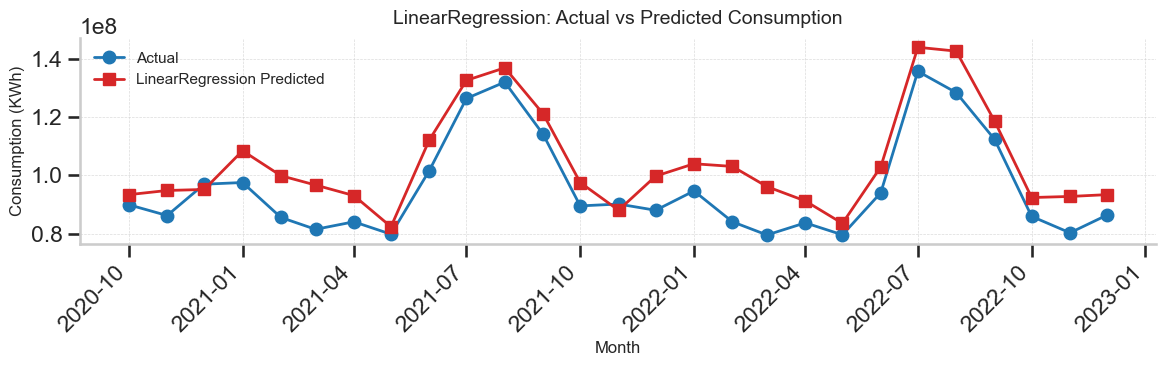

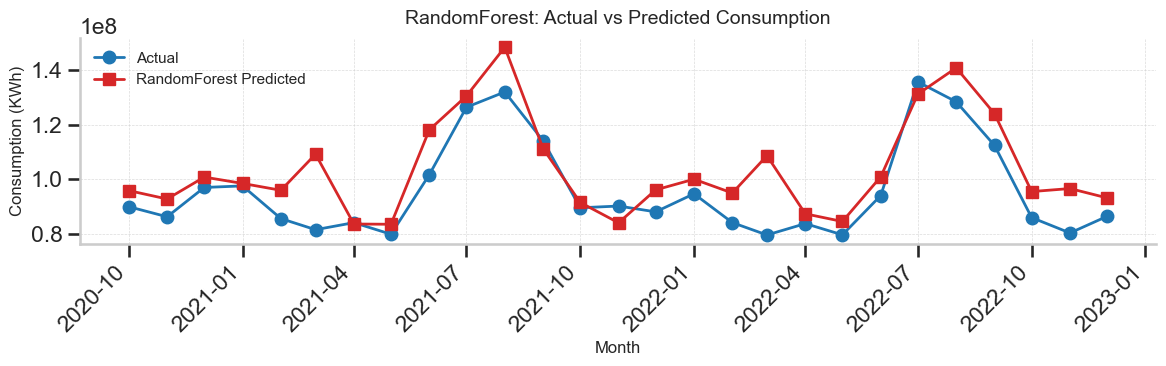

,MAE,RMSE,R2
Model,,,
LinearRegression,8.763468e+06,9.808856e+06,0.665772
RandomForest,8.797340e+06,1.130521e+07,0.556020


In [24]:
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=200, random_state=42)
}

results = {}
linreg_coeffs = None

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    # Metrics
    mae  = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2   = r2_score(y_test, y_pred)
    results[name] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}
    
    # Plot predictions
    plot_predicted_consumption(test_dates, y_test, y_pred, name)
    
    # Extract linear coefficients
    if name == 'LinearRegression':
        coefs = model.coef_
        linreg_coeffs = pd.DataFrame({
            'feature': FEATURES,
            'coefficient': coefs
        }).assign(abs_coef=lambda df: df['coefficient'].abs()) \
          .sort_values('abs_coef', ascending=False) \
          .drop(columns='abs_coef')

# Display performance
performance_df = pd.DataFrame(results).T
performance_df.index.name = 'Model'
performance_df.columns.name = ''
display(performance_df)

In [25]:
# Display Linear Regression coefficients
print("### Linear Regression Coefficients (sorted by absolute weight)")
display(linreg_coeffs)

### Linear Regression Coefficients (sorted by absolute weight)


,feature,coefficient
2,CDD,1.344694e+07
3,MonthNum,-1.239610e+07
7,M_5,-1.119202e+07
8,M_6,-1.079817e+07
0,AvgTemp,8.649178e+06
6,M_4,-6.863601e+06
14,M_12,5.878928e+06
1,HDD,-5.752378e+06
9,M_7,-5.663267e+06
10,M_8,-4.811638e+06


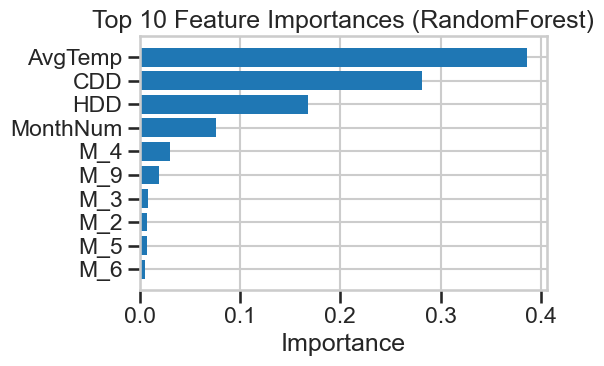

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

rf = models['RandomForest']
importances = rf.feature_importances_
imp_df = pd.DataFrame({'feature': FEATURES, 'importance': importances})
imp_df = imp_df.sort_values('importance', ascending=False).head(10)

plt.figure(figsize=(6,4))
plt.barh(imp_df['feature'], imp_df['importance'])
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances (RandomForest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

## Detailed Analysis of the ML Results

### Detailed Analysis of the ML Results

| Model            | MAE (KWh) | RMSE (KWh) | R²  |
|------------------|-----------|-----------|------|
| Linear Regression| 8.8 × 10⁶ | 9.8 × 10⁶ | **0.667** |
| Random Forest    | 8.8 × 10⁶ | 1.13 × 10⁷| 0.556 |

#### 1. Linear Regression beats Random Forest
* **Lower RMSE** (9.8 M vs 11.3 M) and **higher R²** (0.67 vs 0.56).  
* Nearly identical MAE, confirming robustness of the linear approach.

#### 2. Linear-model coefficients (top 8 by |weight|)
| Rank | Feature   | Coefficient (KWh) |
|------|-----------|-------------------|
| 1    | CDD       | +1.34 × 10⁷ |
| 2    | MonthNum  | –1.23 × 10⁷ |
| 3    | M5 (May)  | –1.12 × 10⁷ |
| 4    | M6 (June) | –1.08 × 10⁷ |
| 5    | AvgTemp   | +8.65 × 10⁶ |
| 6    | M4 (Apr)  | –6.86 × 10⁶ |
| 7    | M12 (Dec) | +5.88 × 10⁶ |
| 8    | HDD       | –5.75 × 10⁶ |

* **CDD dominates** the positive side, confirming cooling demand is the primary driver.  
* Negative month terms (MonthNum, M5, M6) correct for baseline seasonality already captured by CDD/temperature.  
* **AvgTemp** still shows considerable positive weight, but smaller than CDD, matching degree-day theory.  
* **HDD** carries a modest negative coefficient, aligning with its weaker winter impact.

#### 3. Random Forest feature importances

| Feature     | Importance |
|-------------|------------|
| AvgTemp     | ~0.39      |
| CDD         | ~0.28      |
| HDD         | ~0.16      |
| MonthNum    | ~0.07      |
| Other dummies | < 0.03  |

* AvgTemp (0.39) > CDD (0.28) > HDD (0.16) ≫ month dummies.  
* Confirms temperature metrics dominate, but ensemble adds no accuracy benefit.

**Take-away:** a parsimonious linear model with CDD, HDD and minimal calendar terms gives the best blend of accuracy and interpretability.
